In [27]:
import contextlib
from tqdm import tqdm
import joblib
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.patches import Rectangle
from pathlib import Path
from scipy.ndimage import gaussian_filter1d
from scipy.signal import resample_poly

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

from utils import load_pickle,extract_used_data,set_params
from utils.config import Params

In [28]:
def get_data_dict(entry_dir: str):
    path = Path(entry_dir)
    data_dict = {}
    for file in path.glob("*.pkl"):
        data = load_pickle(file)
        data = extract_used_data(data)
        data_dict[file.stem] = data
    return data_dict


def extract_ab_ba(data: dict, params: Params, ana_tt, ana_bt):

    data_AB = []
    data_BA = []

    for index in params.ana_index_grid(ana_tt, ana_bt):

        trial_type = params.tt[index[0]]
        fr = data["simple_firing"][index]
        if fr is None:
            continue

        fr = gaussian_filter1d(fr, sigma=params.gaussian_sigma, axis=2, mode="nearest", truncate=3.0)
        k = params.len_pos_average
        len_track = fr.shape[2]
        fr = fr[:,:,:(len_track - len_track % k)]
        fr = resample_poly(fr, up=1, down=k, axis=2)
        
        if "CAB" in trial_type or "ACB" in trial_type or "ABC" in trial_type:
            data_AB.append(fr)
        elif "CBA" in trial_type or "BCA" in trial_type or "BAC" in trial_type:
            data_BA.append(fr)
        else:
            raise ValueError("Trial type not recognized:", trial_type)

    data_AB = np.concatenate(data_AB, axis=1)
    data_BA = np.concatenate(data_BA, axis=1)

    return data_AB, data_BA

def _clamp_slice(s: int, e: int, T: int) -> tuple[int, int]:
    s = int(s); e = int(e)
    s = max(0, min(s, T))
    e = max(0, min(e, T))
    return s, e

def extract_before_after(data: dict, params: Params, ana_tt: list, ana_bt: list, extend_cm: float = 10.0):

    data_before_a = []
    data_before_b = []
    data_after_a = []
    data_after_b = []
    
    zones = data["zones"]
    zone1_idx = 1
    zone2_idx = 3

    denom = (params.space_unit * params.len_pos_average)
    s1 = int(np.floor((zones[zone1_idx][0] - extend_cm) / denom))
    e1 = int(np.ceil ((zones[zone1_idx][1] + extend_cm) / denom))
    s2 = int(np.floor((zones[zone2_idx][0] - extend_cm) / denom))
    e2 = int(np.ceil ((zones[zone2_idx][1] + extend_cm) / denom))
    
    for index in params.ana_index_grid(ana_tt, ana_bt):

        trial_type = params.tt[index[0]]
        
        assert index[1] == 0, "Only suit for correct trials, but get index[1] = {}".format(index[1])
        
        fr = data["simple_firing"][index]
        if fr is None:
            continue

        fr = gaussian_filter1d(fr, sigma=params.gaussian_sigma, axis=2, mode="nearest", truncate=3.0)
        k = params.len_pos_average
        len_track = fr.shape[2]
        fr = fr[:,:,:(len_track - len_track % k)]
        fr = resample_poly(fr, up=1, down=k, axis=2)
        
        T = fr.shape[2]
        s1c, e1c = _clamp_slice(s1, e1, T)
        s2c, e2c = _clamp_slice(s2, e2, T)
        if (e1c <= s1c) or (e2c <= s2c):
            continue
        
        seg1 = fr[:, :, s1c:e1c]
        seg2 = fr[:, :, s2c:e2c]
        
        if "position" in trial_type:
            if "CAB" in trial_type or "ACB" in trial_type or "ABC" in trial_type:
                data_before_a.append(seg1)
                data_after_b.append(seg2)
            elif "CBA" in trial_type or "BCA" in trial_type or "BAC" in trial_type:
                data_before_b.append(seg1)
                data_after_a.append(seg2)
            else:
                raise ValueError("Trial type not recognized:", trial_type)
        elif "pattern" in trial_type:
            if "CAB" in trial_type:
                data_after_a.append(seg1)
                data_after_b.append(seg2)
            elif "CBA" in trial_type:
                data_after_b.append(seg1)
                data_after_a.append(seg2)
            elif "ACB" in trial_type:
                data_before_a.append(seg1)
                data_after_b.append(seg2)
            elif "BCA" in trial_type:
                data_before_b.append(seg1)
                data_after_a.append(seg2)
            elif "ABC" in trial_type:
                data_before_a.append(seg1)
                data_before_b.append(seg2)
            elif "BAC" in trial_type:
                data_before_b.append(seg1)
                data_before_a.append(seg2)
            else:
                raise ValueError("Trial type not recognized:", trial_type)
        else:
            raise ValueError("Trial type not recognized:", trial_type)
        
    data_before_a = np.concatenate(data_before_a, axis=1)
    data_before_b = np.concatenate(data_before_b, axis=1)
    data_after_a = np.concatenate(data_after_a, axis=1)
    data_after_b = np.concatenate(data_after_b, axis=1)

    return data_before_a, data_before_b, data_after_a, data_after_b


In [29]:
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_cb = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_cb
        tqdm_object.close()

In [30]:
def _task_score_decode(task, X_all, labels, perm_labels, splits, C, max_iter):
    """
    task = (shuffle_idx, fold_idx)
    return: (shuffle_idx, fold_idx, scores)  scores shape (n_time,)
    """
    shuffle_idx, fold_idx = task
    y = labels if shuffle_idx < 0 else perm_labels[shuffle_idx]

    train_idx, test_idx = splits[fold_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    n_time = X_all.shape[2]
    scores = np.empty(n_time, dtype=float)

    for t in range(n_time):
        X_t = X_all[:, :, t].T
        X_train, X_test = X_t[train_idx], X_t[test_idx]

        clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm", LinearSVC(C=C, max_iter=max_iter))
        ])
        clf.fit(X_train, y_train)
        scores[t] = float(clf.score(X_test, y_test))

    return (shuffle_idx, fold_idx, scores)


def decode_and_shuffle(
    data_AB, data_BA,
    n_splits=5, n_repeats=10,
    n_shuffles=500,
    n_jobs=64,
    random_state=0,
    backend="threading",
    C=1.0,
    max_iter=20000,
):
    rng = np.random.RandomState(random_state)

    neurons, n_AB, n_time = data_AB.shape
    _, n_BA, _ = data_BA.shape

    X_all = np.concatenate([data_AB, data_BA], axis=1)  # (neurons, n_trials, n_time)
    labels = np.concatenate([
        np.zeros(n_AB, dtype=int),
        np.ones(n_BA, dtype=int)
    ])  # (n_trials,)

    n_trials = labels.size

    # repeated stratified CV (keeps class ratios)
    cv = RepeatedStratifiedKFold(
        n_splits=n_splits,
        n_repeats=n_repeats,
        random_state=random_state
    )
    splits = list(cv.split(np.zeros(n_trials), labels))
    n_folds = len(splits)

    # pre-generate permuted labels
    perm_labels = np.empty((n_shuffles, n_trials), dtype=int)
    for i in range(n_shuffles):
        perm_labels[i] = rng.permutation(labels)

    tasks = []
    for fold_idx in range(n_folds):
        tasks.append((-1, fold_idx))
    for i_shuf in range(n_shuffles):
        for fold_idx in range(n_folds):
            tasks.append((i_shuf, fold_idx))

    total_tasks = len(tasks)

    pbar = tqdm(total=total_tasks, desc="Shuffle & Decode", dynamic_ncols=True)
    with tqdm_joblib(pbar):
        results = Parallel(n_jobs=n_jobs, backend=backend, inner_max_num_threads=1, batch_size="auto")(
            delayed(_task_score_decode)(task, X_all, labels, perm_labels, splits, C, max_iter)
            for task in tasks
        )

    # aggregate
    scores_real = np.zeros((n_folds, n_time), dtype=float)
    scores_shuffle = np.zeros((n_shuffles, n_folds, n_time), dtype=float)

    for shuf_idx, fold_idx, scores in results:
        if shuf_idx < 0:
            scores_real[fold_idx, :] = scores
        else:
            scores_shuffle[shuf_idx, fold_idx, :] = scores

    mean_acc = np.mean(scores_real, axis=0)
    sem_acc  = np.std(scores_real, axis=0, ddof=1) / np.sqrt(n_folds)

    # shuffle: take mean across folds for each shuffle
    shuffle_means = np.mean(scores_shuffle, axis=1)  # (n_shuffles, n_time)
    shuffle_lower = np.percentile(shuffle_means, 2.5, axis=0)
    shuffle_upper = np.percentile(shuffle_means, 97.5, axis=0)

    # cluster stats (1D over time): same as your original
    sig_mask = mean_acc > shuffle_upper
    clusters = []
    current = None
    for i, v in enumerate(sig_mask):
        if v:
            if current is None:
                current = [i, i]
            else:
                current[1] = i
        else:
            if current is not None:
                clusters.append(tuple(current))
                current = None
    if current:
        clusters.append(tuple(current))

    real_cluster_stats = []
    for start_idx, end_idx in clusters:
        stat = np.sum(mean_acc[start_idx:end_idx+1] - shuffle_upper[start_idx:end_idx+1])
        real_cluster_stats.append((start_idx, end_idx, stat))

    null_cluster_stats = []
    for i in range(n_shuffles):
        perm = shuffle_means[i]
        perm_mask = perm > shuffle_upper
        c = None
        for j, v in enumerate(perm_mask):
            if v:
                if c is None:
                    c = [j, j]
                else:
                    c[1] = j
            else:
                if c is not None:
                    mass = np.sum(perm[c[0]:c[1]+1] - shuffle_upper[c[0]:c[1]+1])
                    null_cluster_stats.append(mass)
                    c = None
        if c:
            mass = np.sum(perm[c[0]:c[1]+1] - shuffle_upper[c[0]:c[1]+1])
            null_cluster_stats.append(mass)

    null_cluster_stats = np.array(null_cluster_stats, dtype=float)

    cluster_signif = []
    for start_idx, end_idx, stat in real_cluster_stats:
        pval = (np.sum(null_cluster_stats >= stat) + 1) / (len(null_cluster_stats) + 1)
        cluster_signif.append((start_idx, end_idx, pval))

    return mean_acc, sem_acc, shuffle_lower, shuffle_upper, cluster_signif


def _task_tgm_chunk(task, X, y, splits, time_idx, C, max_iter):
    """
    task = (fold_idx, chunk_start, chunk_end)
    X: (n_trials, n_neurons, n_time)
    time_idx: (T,) list of used time indices
    return: (fold_idx, chunk_start, rows) rows shape (chunk_len, T)
    """
    fold_idx, cs, ce = task
    train_idx, test_idx = splits[fold_idx]

    y_train = y[train_idx]
    y_test  = y[test_idx]
    T = len(time_idx)

    # test data for all t_test once: (T, n_test, n_neurons)
    X_test_all = X[test_idx][:, :, time_idx]          # (n_test, n_neurons, T)
    X_test_all = np.transpose(X_test_all, (2, 0, 1))  # (T, n_test, n_neurons)

    rows = np.empty((ce - cs, T), dtype=float)

    for ii, t_train in enumerate(time_idx[cs:ce]):
        # TRAIN at one time
        X_train = X[train_idx, :, t_train]  # (n_train, n_neurons)

        # fit scaler ONLY on training to avoid leakage :contentReference[oaicite:5]{index=5}
        scaler = StandardScaler(with_mean=True, with_std=True)
        X_train_z = scaler.fit_transform(X_train)

        mean = scaler.mean_
        scale = scaler.scale_.copy()
        scale[scale == 0] = 1.0

        clf = LinearSVC(C=C, max_iter=max_iter)
        clf.fit(X_train_z, y_train)

        w = clf.coef_.ravel()
        b = float(clf.intercept_[0])

        # standardize all test times in one shot: (T, n_test, n_neurons)
        Xz = (X_test_all - mean[None, None, :]) / scale[None, None, :]

        # decision scores: (T, n_test)
        scores = np.tensordot(Xz, w, axes=([2], [0])) + b

        pred = (scores > 0).astype(int)
        acc  = (pred == y_test[None, :]).mean(axis=1)  # (T,)
        rows[ii, :] = acc

    return fold_idx, cs, rows


def temporal_generalization(
    data_AB, data_BA,
    n_splits=5, n_repeats=10,
    n_jobs=64,
    random_state=0,
    backend="threading",
    C=1.0,
    max_iter=20000,
    chunk_size=10,
):
    data_AB = np.asarray(data_AB, dtype=float)
    data_BA = np.asarray(data_BA, dtype=float)
    n_neurons, n_AB, n_time = data_AB.shape
    _, n_BA, n_time2 = data_BA.shape
    if n_time2 != n_time:
        raise ValueError("data_AB and data_BA must have same n_time")

    X_all = np.concatenate([data_AB, data_BA], axis=1)  # (n_neurons, n_trials, n_time)
    y = np.concatenate([np.zeros(n_AB, int), np.ones(n_BA, int)])
    n_trials = y.size

    # reshape to (n_trials, n_neurons, n_time)
    X = X_all.transpose(1, 0, 2)

    time_idx = np.arange(0, n_time, dtype=int)
    T = len(time_idx)

    cv = RepeatedStratifiedKFold(
        n_splits=n_splits,
        n_repeats=n_repeats,
        random_state=random_state
    )
    splits = list(cv.split(np.zeros(n_trials), y))
    n_folds = len(splits)

    # tasks: (fold, chunk_start, chunk_end)
    tasks = []
    for fold_idx in range(n_folds):
        for cs in range(0, T, chunk_size):
            ce = min(cs + chunk_size, T)
            tasks.append((fold_idx, cs, ce))

    pbar = tqdm(total=len(tasks), desc="TGM", dynamic_ncols=True)
    with tqdm_joblib(pbar):
        results = Parallel(n_jobs=n_jobs, backend=backend)(
            delayed(_task_tgm_chunk)(task, X, y, splits, time_idx, C, max_iter)
            for task in tasks
        )

    # aggregate across folds using sum & sumsq
    sum_mat = np.zeros((T, T), dtype=float)
    sumsq_mat = np.zeros((T, T), dtype=float)

    for fold_idx, cs, rows in results:
        ce = cs + rows.shape[0]
        sum_mat[cs:ce, :] += rows
        sumsq_mat[cs:ce, :] += rows * rows

    tgm_mean = sum_mat / n_folds

    if n_folds > 1:
        var = (sumsq_mat - (sum_mat * sum_mat) / n_folds) / (n_folds - 1)
        var = np.maximum(var, 0.0)
        tgm_sem = np.sqrt(var / n_folds)
    else:
        tgm_sem = np.zeros_like(tgm_mean)

    return tgm_mean, tgm_sem


# mean_acc, sem_acc, shuf_lo, shuf_hi, clusters = decode_and_shuffle(
#     data_AB, data_BA,
#     n_splits=5, n_repeats=10,
#     n_shuffles=100,
#     n_jobs=12,
#     backend="threading",   # or "loky"
#     random_state=0
# )
#
# tgm_mean, tgm_sem, time_idx = temporal_generalization_no_perm(
#     data_AB, data_BA,
#     n_splits=5, n_repeats=10,
#     n_jobs=12,
#     backend="threading",
#     time_stride=1,
#     chunk_size=10
# )


In [31]:
def plot_decoding_with_zones(data: dict, params: Params, mean_acc, sem_acc, shuffle_lower, shuffle_upper, cluster_signif):

    n_time = len(mean_acc)
    X = np.arange(n_time)

    zones_color = {
        1: "#1f77b4",
        3: "#1f77b4",
    }
    acc_color = "#2ca02c"


    plt.figure(figsize=(6, 3))
    ax = plt.gca()

    # mean + sem
    ax.plot(X, mean_acc, color=acc_color)
    ax.fill_between(X, mean_acc - sem_acc, mean_acc + sem_acc, color=acc_color, alpha=0.4)

    # shuffle band
    ax.fill_between(X, shuffle_lower, shuffle_upper, color="gray", alpha=0.4)

    # chance line
    ax.axhline(0.5, linestyle="--", color="k")

    # cluster significance highlight
    for start, end, p in cluster_signif:
        if p < 0.05:
            ax.axvspan(start, end, facecolor="black", alpha=0.2)

    # zones background (horizontal bars)
    x0, x1 = ax.get_xlim()
    eps = 0.002 * (x1 - x0)
    h_frac = 0.05

    zones = data["zones"]

    for zi, row in enumerate(zones):

        if zi not in zones_color: continue

        start_x = row[0] / params.space_unit / params.len_pos_average
        end_x   = row[1]   / params.space_unit / params.len_pos_average

        ax.axvline(start_x, linestyle="--", color="k", linewidth=1)
        ax.axvline(end_x,   linestyle="--", color="k", linewidth=1)

        color_zone = zones_color[zi]

        # rect = Rectangle(
        #     (start_x - eps, 1.0 - h_frac),
        #     end_x - start_x + 2*eps, h_frac,
        #     transform=ax.get_xaxis_transform(),
        #     facecolor=color_zone,
        #     edgecolor="none",
        #     clip_on=False,
        #     zorder=6,
        # )
        # ax.add_patch(rect)

    # aesthetics
    ax.set_ylim(0, 1.02)
    ax.set_xlabel("Position (cm)", fontsize=12)
    ax.set_ylabel("Accuracy", fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, pos: f"{x*params.space_unit*params.len_pos_average:g}")
    )
    ax.tick_params(labelsize=12)
    plt.tight_layout()
    plt.show()

In [32]:
def plot_decoding_bf(mean_acc_before, sem_acc_before, mean_acc_after, sem_acc_after, shuffle_lower_before, shuffle_upper_before, shuffle_lower_after, shuffle_upper_after, clusters_before, clusters_after):
    n_time = len(mean_acc_before)
    X = np.arange(n_time)
    
    acc_color = "#2ca02c"
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
    
    # Left plot (Before Reward)
    # mean + sem for before reward
    ax1.plot(X, mean_acc_before, color=acc_color, label="SVM Decoding (Before Reward)")
    ax1.fill_between(X, mean_acc_before - sem_acc_before, mean_acc_before + sem_acc_before, color=acc_color, alpha=0.4)

    # shuffle band for before reward
    ax1.fill_between(X, shuffle_lower_before, shuffle_upper_before, color="gray", alpha=0.4)

    # chance line
    ax1.axhline(0.5, linestyle="--", color="k")

    # cluster significance highlight for before reward
    for start, end, p in clusters_before:
        if p < 0.05:
            ax1.axvspan(start, end, facecolor="black", alpha=0.2)

    # Aesthetics for left plot
    ax1.set_ylim(0, 1.02)
    ax1.set_xlabel("Region before Reward", fontsize=12)
    ax1.set_ylabel("Accuracy", fontsize=12)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.xaxis.set_ticks_position('bottom')
    ax1.yaxis.set_ticks_position('left')
    ax1.tick_params(labelsize=12)
    ax1.xaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, pos: f"{x - n_time//2:g}")
    )

    # Right plot (After Reward)
    # mean + sem for after reward
    ax2.plot(X, mean_acc_after, color=acc_color, label="SVM Decoding (After Reward)")
    ax2.fill_between(X, mean_acc_after - sem_acc_after, mean_acc_after + sem_acc_after, color=acc_color, alpha=0.4)

    # shuffle band for after reward
    ax2.fill_between(X, shuffle_lower_after, shuffle_upper_after, color="gray", alpha=0.4)

    # chance line
    ax2.axhline(0.5, linestyle="--", color="k")

    # cluster significance highlight for after reward
    for start, end, p in clusters_after:
        if p < 0.05:
            ax2.axvspan(start, end, facecolor="black", alpha=0.2)

    # Aesthetics for right plot
    ax2.set_ylim(0, 1.02)
    ax2.set_xlabel("Region after Reward", fontsize=12)
    ax2.set_ylabel("Accuracy", fontsize=12)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.xaxis.set_ticks_position('bottom')
    ax2.yaxis.set_ticks_position('left')
    ax2.tick_params(labelsize=12)
    ax2.xaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, pos: f"{x - n_time//2:g}")
    )
    
    # Tight layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [33]:
def plot_tgm_heatmap(
    data: dict,
    params: Params,
    tgm_mean: np.ndarray,
    *,
    vmin: float | None = None,
    vmax: float | None = None,
    show_diag: bool = True,
    show_zones: bool = True,
):

    tgm_mean = np.asarray(tgm_mean, dtype=float)
    if tgm_mean.ndim != 2 or tgm_mean.shape[0] != tgm_mean.shape[1]:
        raise ValueError("tgm_mean must be a square 2D array (T, T)")
    T = tgm_mean.shape[0]

    time_idx = np.arange(T, dtype=float)

    bin_cm = float(params.space_unit * params.len_pos_average)
    coord = time_idx * bin_cm
    xlabel = "Test position (cm)"
    ylabel = "Train position (cm)"
    tick_formatter = mticker.FuncFormatter(lambda x, pos: f"{x:g}")

    if T > 1:
        d = float(coord[1] - coord[0])
    else:
        d = 1.0
    extent = [coord[0] - d/2, coord[-1] + d/2, coord[0] - d/2, coord[-1] + d/2]

    chance = 0.5
    if vmin is None or vmax is None:
        dev = np.nanmax(np.abs(tgm_mean - chance))
        if not np.isfinite(dev) or dev == 0:
            dev = 0.05
        if vmin is None:
            vmin = chance - dev
        if vmax is None:
            vmax = chance + dev
    
    fig = plt.figure(figsize=(6, 5))
    ax = fig.gca()
    title = "Temporal generalization"
    cbar_labels = "Score"

    cmap = "viridis"
    im = ax.imshow(
        tgm_mean,
        origin="lower",
        extent=extent,
        aspect="auto",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        interpolation="nearest",
    )

    ax.set_title(title, fontsize=13)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.xaxis.set_ticks_position("bottom")
    ax.yaxis.set_ticks_position("left")
    if tick_formatter is not None:
        ax.xaxis.set_major_formatter(tick_formatter)
        ax.yaxis.set_major_formatter(tick_formatter)

    if show_diag:
        ax.plot([coord[0], coord[-1]], [coord[0], coord[-1]], linestyle="--", linewidth=0.8, color="k", alpha=0.6)

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(cbar_labels, fontsize=11)

    zones = data["zones"]
    zones_color = {
        1: "#1f77b4",
        3: "#1f77b4",
    }

    if show_zones and zones is not None and len(zones) > 0 and params is not None:

        for zi, row in enumerate(zones):

            if zi not in zones_color: continue

            start_x = row[0]
            end_x   = row[1]

            ax.axvline(start_x, linestyle="--", color="k", linewidth=0.8)
            ax.axvline(end_x,   linestyle="--", color="k", linewidth=0.8)
            ax.axhline(start_x, linestyle="--", color="k", linewidth=0.8)
            ax.axhline(end_x,   linestyle="--", color="k", linewidth=0.8)

    plt.tight_layout()
    plt.show()

In [34]:
def run_on(entry_dir, params, ana_tt, ana_bt):
    
    data_dict = get_data_dict(entry_dir)

    for key, data in data_dict.items():
        print("===============")
        print(key)
        print("===============")
        data_AB, data_BA = extract_ab_ba(data, params, ana_tt, ana_bt)
        mean_acc, sem_acc, shuf_lo, shuf_hi, clusters = decode_and_shuffle(data_AB, data_BA, backend="loky")
        plot_decoding_with_zones(data, params, mean_acc, sem_acc, shuf_lo, shuf_hi, clusters)
        tgm_mean, _ = temporal_generalization(data_AB, data_BA)
        plot_tgm_heatmap(data, params, tgm_mean, vmin=0.2, vmax=0.8)
        
        
def run_on2(entry_dir, params, ana_tt, ana_bt):

    data_dict = get_data_dict(entry_dir)

    for key, data in data_dict.items():
        print("===============")
        print(key)
        print("===============")
        data_before_a, data_before_b, data_after_a, data_after_b = extract_before_after(data, params, ana_tt, ana_bt, extend_cm=25.0)
        mean_acc_before, sem_acc_before, shuf_lo_before, shuf_hi_before, clusters_before = decode_and_shuffle(data_before_a, data_before_b, backend="loky")
        mean_acc_after, sem_acc_after, shuf_lo_after, shuf_hi_after, clusters_after = decode_and_shuffle(data_after_a, data_after_b, backend="loky")
        plot_decoding_bf(mean_acc_before, sem_acc_before, mean_acc_after, sem_acc_after, shuf_lo_before, shuf_hi_before, shuf_lo_after, shuf_hi_after, clusters_before, clusters_after)
        


RA02-PFCsep


Shuffle & Decode: 100%|██████████| 25050/25050 [01:45<00:00, 236.47it/s]


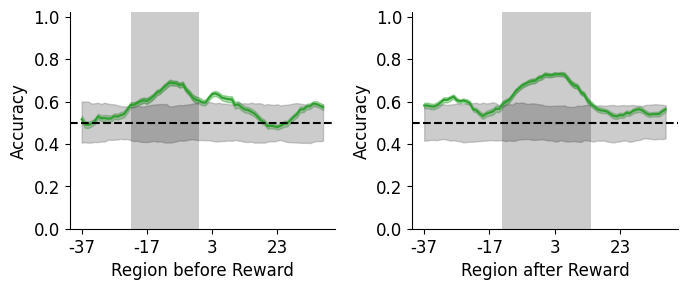

RDH01-PFCsep2


Shuffle & Decode: 100%|██████████| 25050/25050 [03:54<00:00, 106.92it/s]


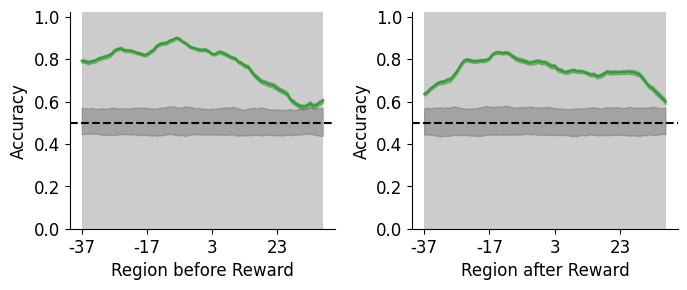

RDH01-PFCsep1


Shuffle & Decode: 100%|██████████| 25050/25050 [01:59<00:00, 209.09it/s]


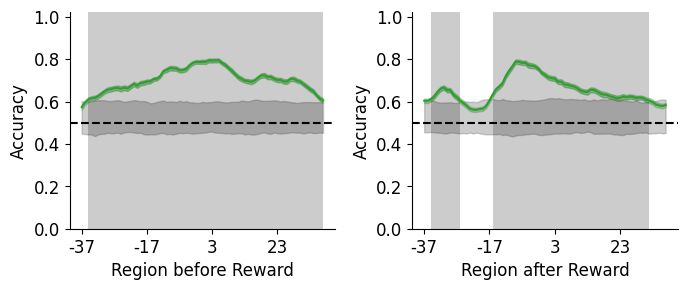

RC03-PFCsep


Shuffle & Decode: 100%|██████████| 25050/25050 [01:02<00:00, 401.36it/s]


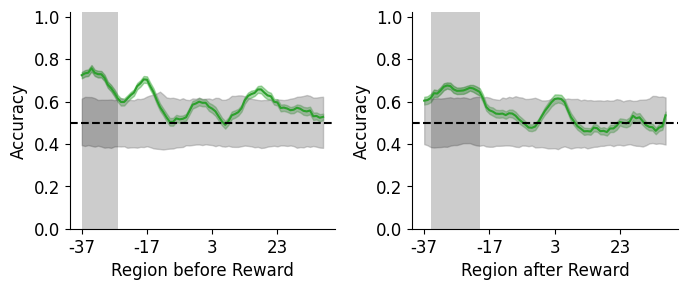

RDP02-PFCsep


Shuffle & Decode: 100%|██████████| 25050/25050 [01:30<00:00, 277.99it/s]


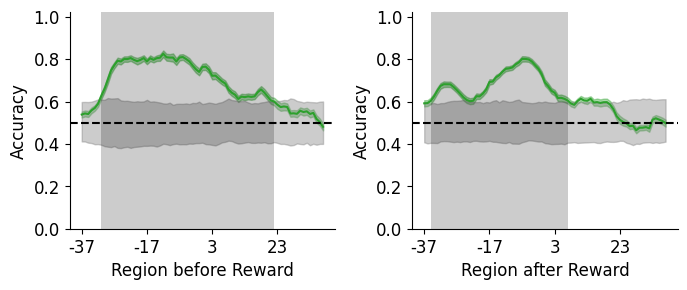

In [35]:
entry_dir = "../../data/flexible_shift/"

params = set_params(tt_preset="basic",
                    bt_preset="basic",
                    len_pos_average=10,
                    gaussian_sigma=50)

ana_tt=["*"]
ana_bt=["correct"]

run_on2(entry_dir, params, ana_tt, ana_bt)

In [36]:
# entry_dir = "../../data/first_to_pat/"

# params = set_params(tt_preset="basic",
#                     bt_preset="basic",
#                     len_pos_average=10,
#                     gaussian_sigma=50)

# ana_tt=["couple*"]
# ana_bt=["*"]

# run_on(entry_dir, params, ana_tt, ana_bt)

In [37]:
# entry_dir = "../../data/first_to_pat/"

# params = set_params(tt_preset="basic",
#                     bt_preset="basic",
#                     len_pos_average=10,
#                     gaussian_sigma=50)

# ana_tt=["pattern*"]
# ana_bt=["*"]

# run_on(entry_dir, params, ana_tt, ana_bt)

In [38]:
# entry_dir = "../../data/first_to_pos/"

# params = set_params(tt_preset="basic",
#                     bt_preset="basic",
#                     len_pos_average=10,
#                     gaussian_sigma=50)

# ana_tt=["couple*"]
# ana_bt=["*"]

# run_on(entry_dir, params, ana_tt, ana_bt)

In [39]:
# entry_dir = "../../data/first_to_pos/"

# params = set_params(tt_preset="basic",
#                     bt_preset="basic",
#                     len_pos_average=10,
#                     gaussian_sigma=50)

# ana_tt=["position*"]
# ana_bt=["*"]

# run_on(entry_dir, params, ana_tt, ana_bt)

In [40]:
# entry_dir = "../../data/one_rule/pattern"

# params = set_params(tt_preset="basic",
#                     bt_preset="basic",
#                     len_pos_average=10,
#                     gaussian_sigma=50)

# ana_tt=["pattern*"]
# ana_bt=["*"]

# run_on(entry_dir, params, ana_tt, ana_bt)

In [41]:
# entry_dir = "../../data/one_rule/position"

# params = set_params(tt_preset="basic",
#                     bt_preset="basic",
#                     len_pos_average=10,
#                     gaussian_sigma=50)

# ana_tt=["position*"]
# ana_bt=["*"]

# run_on(entry_dir, params, ana_tt, ana_bt)